In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd

In [4]:
shapefile_path = 'data/hydrobasins_lvl6/hybas_as_lev06_v1c.shp'
shapes = gpd.read_file(shapefile_path)

In [5]:
def get_precip_data_for_year(data_path, shapes):
    dataset = xr.open_dataset(data_path)
    
    sums = []
    
    for index, shape in shapes.iterrows():
        # Extract the geometry
        geom = shape.geometry

        # Select the data from the NetCDF file using the geometry
        # because \nearest\ method is used, even if there is no data
        # , it will calculate an average for data nearest to it
        # this makes it appear like there is data for areas where there is none (e.g., in Japan).
        # TODO : needs to label whether a shape is part of tibetan plateau or not
        data = dataset.sel(longitude=geom.centroid.x, latitude=geom.centroid.y, method='nearest')
        # data = dataset.sel(longitude=geom.centroid.x, latitude=geom.centroid.y, method=None)

        # Calculate the sum of the data
        # data_sum = data.sum()
        data_sum = data.sum()['tp'].values

        # Append the sum to the list
        sums.append(data_sum)
        
    return sums


In [6]:
years = np.arange(2000, 2022, 1)

final_data_set = pd.DataFrame()

for year in years:
    precip = get_precip_data_for_year(f'data/precip/{year}/data.nc', shapes=shapes)
    year_df = pd.DataFrame()
    year_df['precip'] = precip
    year_df['precip'] = year_df['precip'].astype(np.float64)
    year_df['year'] = year
    final_data_set = pd.concat([final_data_set, year_df])
    
final_data_set.head()

,precip,year
0,0.082391,2000
1,0.082391,2000
2,0.082391,2000
3,0.082391,2000
4,0.082391,2000


In [11]:
# Calculate the centroid of each shape and add a marker to the map
shapes['centroid_lon'] = shapes.apply(lambda row: row['geometry'].centroid.x, axis=1)
shapes['centroid_lat'] = shapes.apply(lambda row: row['geometry'].centroid.y, axis=1)

In [12]:
final_data_set = final_data_set.join(shapes).sort_values(by=['year', 'SORT'])
final_data_set = gpd.GeoDataFrame(final_data_set)

# bounding box from precip data
xmin = 45
xmax = 107
ymin = 24
ymax = 68

final_data_set = final_data_set.cx[xmin:xmax, ymin:ymax]


final_data_set.describe()
final_data_set.head()

,precip,year,HYBAS_ID,NEXT_DOWN,NEXT_SINK,MAIN_BAS,DIST_SINK,DIST_MAIN,SUB_AREA,UP_AREA,PFAF_ID,ENDO,COAST,ORDER,SORT,geometry,centroid_lon,centroid_lat
447,0.910646,2000,4060631960,4060629690,4060007850,4060007850,1356.8,1356.8,28426.8,51783.5,432270,0,0,2,448,"POLYGON ((108.86667 34.43750, 108.88138 34.438...",107.535213,34.395430
451,0.650587,2000,4060611660,4060631880,4060007850,4060007850,1527.2,1527.2,4221.8,4222.0,432262,0,0,4,452,"POLYGON ((106.58750 35.12083, 106.58807 35.127...",107.389148,35.047425
453,0.621524,2000,4060606120,4060611300,4060007850,4060007850,1552.4,1552.4,14418.8,14418.8,432264,0,0,4,454,"POLYGON ((107.41667 35.30000, 107.40174 35.300...",106.924689,35.716825
462,0.540041,2000,4060583100,4060606020,4060007850,4060007850,1649.8,1649.8,5961.4,10598.4,432267,0,0,3,463,"POLYGON ((107.67917 36.41667, 107.67981 36.410...",107.294046,36.419078
472,0.651469,2000,4060625230,4060631960,4060007850,4060007850,1753.2,1753.2,10713.7,10713.7,432290,0,0,2,473,"POLYGON ((106.29583 35.29167, 106.30662 35.291...",105.759122,35.404014


In [24]:
final_data_set.drop_duplicates(subset=['precip'], inplace=True)

In [51]:
final_data_set.dropna().shape

(23983, 18)

In [25]:
precip_per_year = final_data_set.pivot(index='year', columns='HYBAS_ID', values='precip')

''

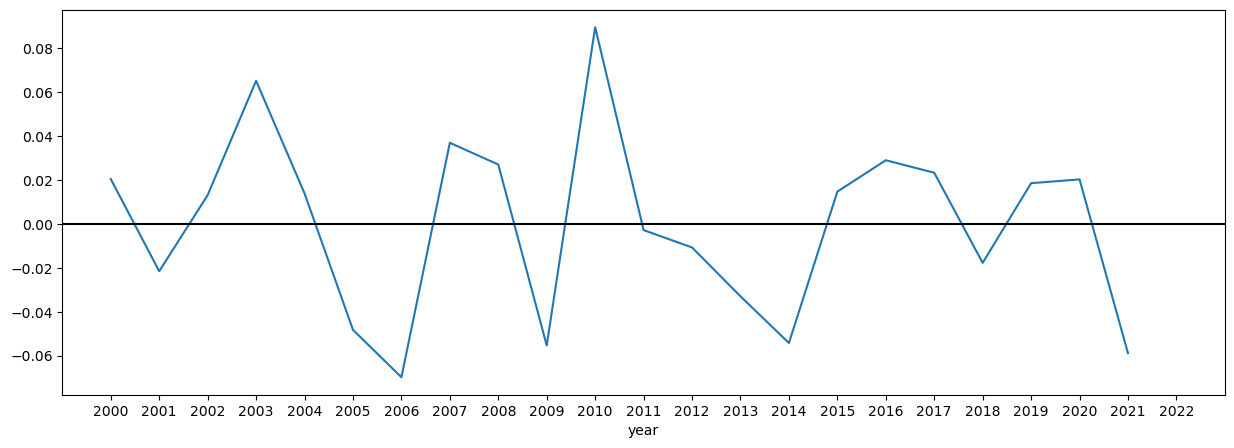

In [89]:
fig, ax = plt.subplots(figsize=(15, 5))
# precip_per_year.plot(legend=False, color='black', alpha=0.05, ax=ax)

mu = precip_per_year.mean(axis=1)
si = precip_per_year.sem(axis=1)

# ax.errorbar(precip_per_year.index, mu, si, color='red', capsize=3)
# ax.set_ylim(-2, 2)

x = precip_per_year.values.flatten()
# x[x==np.isnan(x)] = 0
mu_agg = np.nanmean(x)
st_agg = np.nanstd(x)

mu_agg = precip_per_year.apply(lambda row: (row - mu_agg)/st_agg)
# mu_agg.plot(legend=False, color='red', ax=ax, alpha=0.15)
mu_agg.mean(axis=1).plot(ax=ax)
ax.plot((1999, 2023), (0, 0), color='black',)
ax.set_xlim(1999, 2023)
ax.set_xticks(np.arange(2000, 2023, 1))
''